<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/NN-Time-series/blob/main/gait_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-45dd80f8-a8f2-9835-7357-7bc097f32e65)


# Processing IGAIT data

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
side_df  = pd.read_csv("side_dataset_time_series_norm.csv")
front_df = pd.read_csv("front_dataset_time_series_norm.csv")
uni_df = pd.read_csv("univariate_data.csv")

# Encode categorical directions
side_map  = {'left': 0, 'right': 1, 'stationary': 2}
front_map = {'towards': 0, 'backwards': 1}
side_df['DirCode']  = side_df['Direction'].map(side_map)
front_df['DirCode'] = front_df['Direction'].map(front_map)

# Sorted list of subjects
subjects = sorted(side_df['subject'].unique())
print(f"Subjects: {subjects}")
n = len(subjects)  # e.g., 53 subjects
print(f"Number of Subjects: {n}")

# Initialize arrays
side_data  = np.zeros((n, 300, 9))
front_data = np.zeros((n, 249, 4))
uni_features = []
S_size=[]
F_size=[]
for i, subj in enumerate(subjects):
    # Side data
    sub_side  = side_df[side_df['subject'] == subj].sort_values('frame')
    num_cols_side = ['RightHipAngle', 'LeftHipAngle', 'RightKneeAngle', 'LeftKneeAngle',
                     'Right Ankle Angle', 'Left Ankle Angle',
                     'Right Dorsi Plantar Angle', 'Left Dorsi Plantar Angle']
    side_feat = np.hstack([sub_side[['DirCode']].to_numpy(), sub_side[num_cols_side].to_numpy()])
    L = side_feat.shape[0]
    S_size.append(L)
    # print(f"side_feat {side_feat}, L : {L}")
    side_data[i] = side_feat[:300] if L >= 300 else np.vstack([side_feat, np.zeros((300 - L, 9))])

    # Front data
    sub_front = front_df[front_df['subject'] == subj].sort_values('frame')
    num_cols_front = ['R_Adduction_Abduction', 'L_Adduction_Abduction', 'Step_Width']
    front_feat = np.hstack([sub_front[['DirCode']].to_numpy(), sub_front[num_cols_front].to_numpy()])
    Lf = front_feat.shape[0]
    F_size.append(Lf)
    front_data[i] = front_feat[:249] if Lf >= 249 else np.vstack([front_feat, np.zeros((249 - Lf, 4))])

    # Univariate features
    row = uni_df[uni_df['Subject'] == subj]
    cadence = row['Cadence'].values[0]
    step_length = row['StepLength'].values[0]
    stride_length = row['StrideLength'].values[0]
    uni_features.append([cadence, step_length, stride_length])

# Convert to NumPy array
uni_features = np.array(uni_features)  # shape: (53, 3)
print("Side size",S_size)
print("Front size",F_size)

# Labels
labels = np.array([int(side_df[side_df['subject'] == subj]['label'].iloc[0]) for subj in subjects])
# print(f"side data: {side_data[0][0]}")
print(f"Original Labels: {labels}")
# Train-test split
X_side_train, X_side_test, X_front_train, X_front_test, X_uni_train, X_uni_test, y_train, y_test = train_test_split(
    side_data, front_data, uni_features, labels,
    test_size=0.2, random_state=41, stratify=labels
)


Subjects: [np.int64(101), np.int64(102), np.int64(103), np.int64(104), np.int64(105), np.int64(106), np.int64(107), np.int64(108), np.int64(109), np.int64(110), np.int64(111), np.int64(112), np.int64(113), np.int64(114), np.int64(115), np.int64(116), np.int64(117), np.int64(118), np.int64(119), np.int64(120), np.int64(121), np.int64(122), np.int64(123), np.int64(124), np.int64(125), np.int64(126), np.int64(127), np.int64(128), np.int64(129), np.int64(130), np.int64(131), np.int64(132), np.int64(133), np.int64(134), np.int64(201), np.int64(202), np.int64(203), np.int64(204), np.int64(205), np.int64(206), np.int64(207), np.int64(208), np.int64(209), np.int64(210), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216), np.int64(217), np.int64(218), np.int64(219)]
Number of Subjects: 53
Side size [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 279, 300, 300, 300, 300, 283, 300, 300, 300, 258, 262, 300, 300, 300, 300, 

In [65]:
y_train

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [66]:
X_side_train[0][0], X_side_train.shape, X_side_test[0],X_side_test.shape

(array([ 0.        ,  0.11545204,  0.19845432,  0.32656062,  0.01991485,
         0.27585829,  0.32769902, -0.10970865,  0.36992626]),
 (42, 300, 9),
 array([[ 0.        ,  0.31962827,  0.22769824, ...,  0.2120932 ,
          0.42700468, -0.20395639],
        [ 0.        ,  0.29484652,  0.30121145, ...,  0.13609467,
          0.42700468, -0.26586088],
        [ 2.        ,  0.32779499,  0.49449339, ...,  0.14811391,
          0.42700468, -0.16384926],
        ...,
        [ 0.        ,  0.66319347,  0.39537445, ...,  0.46523669,
         -2.54840354,  0.28648408],
        [ 0.        ,  0.65502675,  0.30644273, ...,  0.86797337,
          0.42822662, -3.36588065],
        [ 0.        ,  0.68177978,  0.38573789, ...,  0.62777367,
          0.42456082, -2.69190645]]),
 (11, 300, 9))

In [67]:
X_front_train[0][0],X_front_train.shape,X_front_test.shape,

(array([0.        , 1.36854958, 0.17537953, 0.6890971 ]),
 (42, 249, 4),
 (11, 249, 4))

In [68]:
X_uni_train,X_uni_train.shape

(array([[1.87, 2.74, 5.49],
        [2.04, 1.22, 2.43],
        [2.26, 2.04, 4.08],
        [2.16, 2.07, 4.13],
        [1.9 , 2.28, 4.55],
        [1.84, 1.81, 3.63],
        [2.14, 2.21, 4.41],
        [2.1 , 2.28, 4.55],
        [2.04, 2.97, 5.94],
        [2.37, 1.49, 2.98],
        [1.91, 1.69, 3.39],
        [2.16, 1.64, 3.28],
        [2.03, 2.16, 4.33],
        [1.99, 1.75, 3.5 ],
        [2.28, 1.66, 3.32],
        [2.08, 1.44, 2.89],
        [2.28, 2.13, 4.27],
        [2.05, 2.11, 4.22],
        [2.18, 1.76, 3.53],
        [2.23, 1.46, 2.91],
        [1.92, 2.16, 4.32],
        [1.93, 2.42, 4.84],
        [1.85, 1.83, 3.67],
        [2.19, 1.67, 3.34],
        [1.93, 2.63, 5.26],
        [2.18, 2.15, 4.31],
        [1.86, 2.32, 4.65],
        [1.92, 2.32, 4.63],
        [1.95, 1.96, 3.92],
        [2.18, 2.77, 5.53],
        [1.91, 2.34, 4.68],
        [1.84, 1.38, 2.77],
        [1.84, 2.28, 4.56],
        [2.33, 2.78, 5.55],
        [1.59, 2.73, 5.46],
        [2.27, 1.7 ,

In [69]:
y_train[:20]

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1])

# Model Architecture


In [78]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, LSTM,
                                     Dense, Dropout, BatchNormalization, Activation, concatenate)
from tensorflow.keras.models import Model

# ----------- Side-view subnetwork -----------
side_input = Input(shape=(300, 9), name='side_input')

# Conv1D to extract local patterns
x_side = Conv1D(64, 3, padding='same', activation='relu')(side_input)
x_side = MaxPooling1D(2)(x_side)
x_side = BatchNormalization()(x_side)

# LSTM for long-term temporal patterns
x_side = LSTM(64, return_sequences=False)(x_side)

# ----------- Front-view subnetwork -----------
front_input = Input(shape=(249, 4), name='front_input')

x_front = Conv1D(32, 3, padding='same', activation='relu')(front_input)
x_front = MaxPooling1D(2)(x_front)
x_front = BatchNormalization()(x_front)

x_front = LSTM(32, return_sequences=False)(x_front)

# ----------- Univariate subnetwork -----------
uni_input = Input(shape=(3,), name='uni_input')
x_uni = Dense(32)(uni_input)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)
x_uni = Dropout(0.5)(x_uni)

x_uni = Dense(16)(x_uni)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)

# ----------- Merge all streams -----------
merged = concatenate([x_side, x_front, x_uni])
z = Dense(64)(merged)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dropout(0.5)(z)

output = Dense(1, activation='sigmoid', name='output')(z)

# ----------- Build model -----------
model = Model(inputs=[side_input, front_input, uni_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ uni_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │        128 │ uni_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 300, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_input         │ (None, 249, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 300, 64)   │      1,792 │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 249, 32)   │        416 │ front_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 150, 64)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 124, 32)   │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │        528 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 64)   │        256 │ max_pooling1d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 32)   │        128 │ max_pooling1d_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │      8,320 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 16)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 112)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0],   

 Total params: 52,337 (204.44 KB)

 Trainable params: 51,921 (202.82 KB)

 Non-trainable params: 416 (1.62 KB)

In [89]:
# import tensorflow as tf
# from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
#                                      Dense, Dropout, BatchNormalization, Activation, concatenate)
# from tensorflow.keras.models import Model

# # Side-view subnetwork
# side_input = Input(shape=(300, 9), name='side_input')
# x_side = Conv1D(32, 3, activation=None)(side_input)
# x_side = BatchNormalization()(x_side)
# x_side = Activation('relu')(x_side)
# x_side = MaxPooling1D(2)(x_side)

# x_side = Conv1D(64, 3, activation=None)(x_side)
# x_side = BatchNormalization()(x_side)
# x_side = Activation('relu')(x_side)
# x_side = GlobalAveragePooling1D()(x_side)

# # Front-view subnetwork
# front_input = Input(shape=(249, 4), name='front_input')
# x_front = Conv1D(16, 3, activation=None)(front_input)
# x_front = BatchNormalization()(x_front)
# x_front = Activation('relu')(x_front)
# x_front = MaxPooling1D(2)(x_front)

# x_front = Conv1D(32, 3, activation=None)(x_front)
# x_front = BatchNormalization()(x_front)
# x_front = Activation('relu')(x_front)
# x_front = GlobalAveragePooling1D()(x_front)

# # Univariate-features subnetwork
# uni_input = Input(shape=(3,), name='uni_input')
# x_uni = Dense(32, activation=None)(uni_input)
# x_uni = BatchNormalization()(x_uni)
# x_uni = Activation('relu')(x_uni)
# x_uni = Dropout(0.5)(x_uni)

# x_uni = Dense(16, activation=None)(x_uni)
# x_uni = BatchNormalization()(x_uni)
# x_uni = Activation('relu')(x_uni)

# # Concatenate all features
# merged = concatenate([x_side, x_front, x_uni])
# z = Dense(64, activation=None)(merged)
# z = BatchNormalization()(z)
# z = Activation('relu')(z)
# z = Dropout(0.5)(z)

# output = Dense(1, activation='sigmoid', name='output')(z)

# # Build and compile model
# model = Model(inputs=[side_input, front_input, uni_input], outputs=output)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


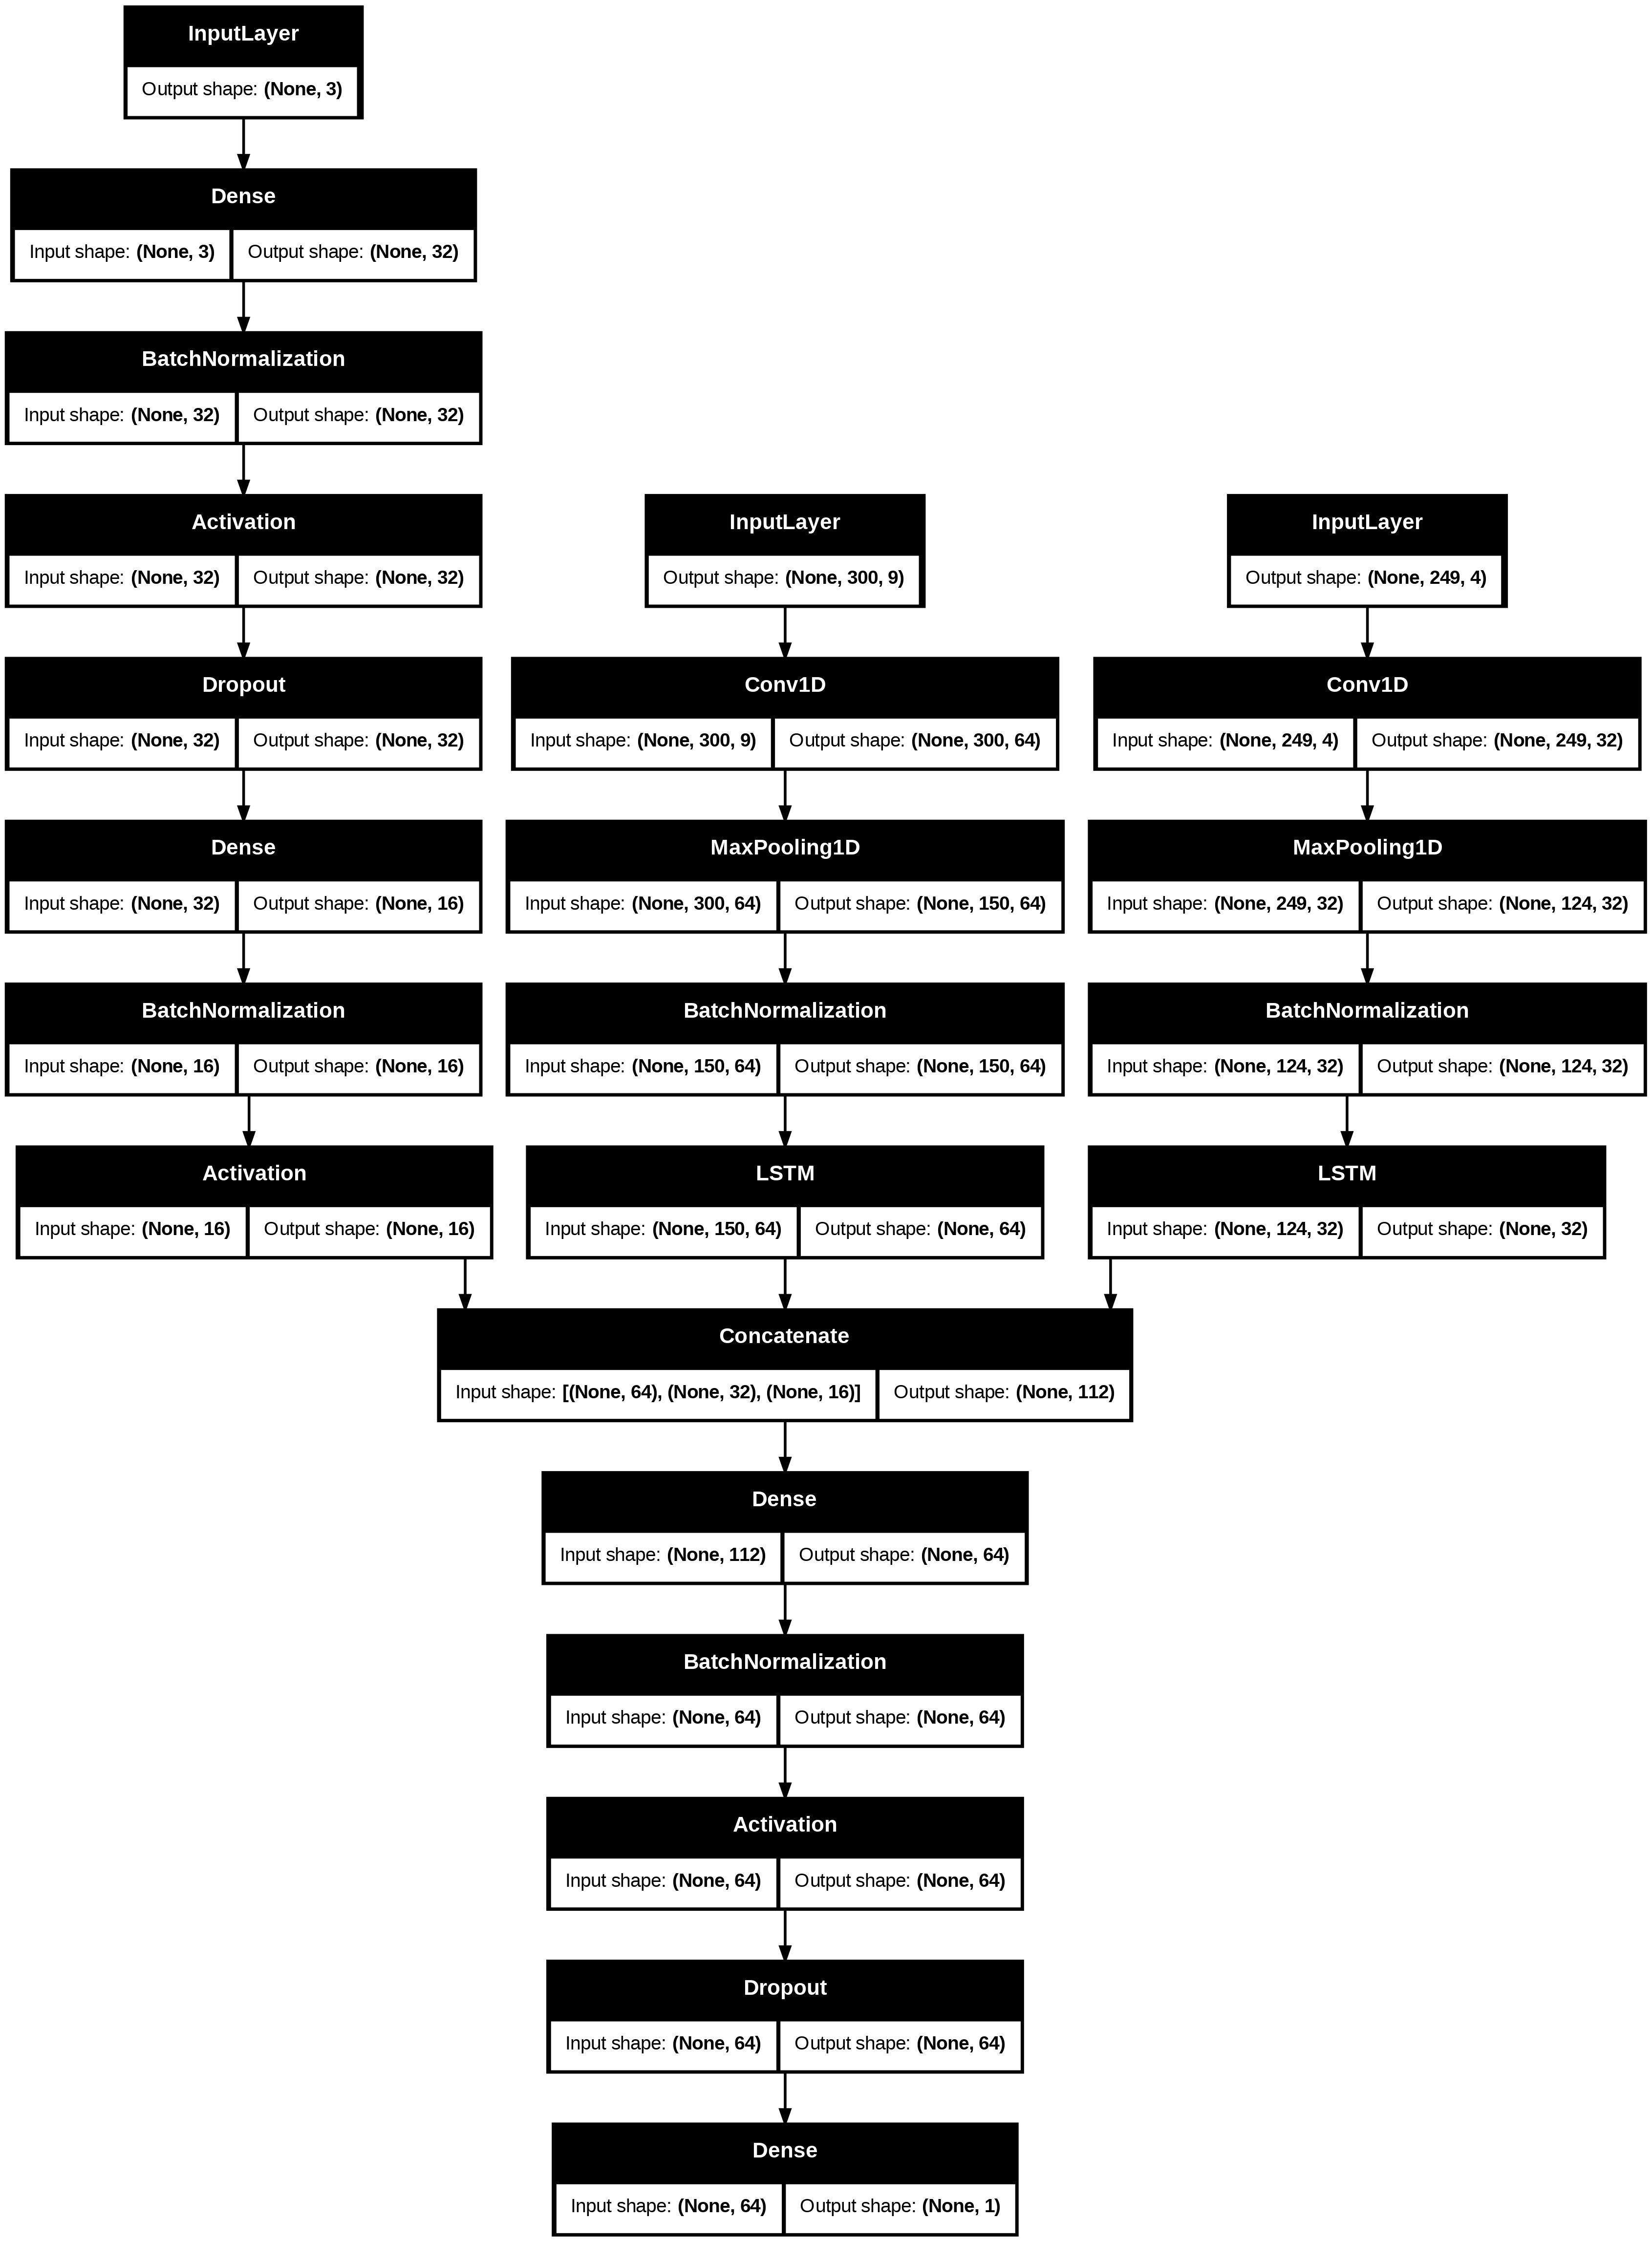

In [79]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [72]:
print("Side NaNs:", np.isnan(X_side_train).sum())
print("Front NaNs:", np.isnan(X_front_train).sum())
print("Uni NaNs:", np.isnan(X_uni_train).sum())

print("Side NaNs:", np.isnan(X_side_test).sum())
print("Front NaNs:", np.isnan(X_front_test).sum())
print("Uni NaNs:", np.isnan(X_uni_test).sum())
print("----------")
print("Side Infs:", np.isinf(X_side_train).sum())
print("Front Infs:", np.isinf(X_front_train).sum())
print("Uni Infs:", np.isinf(X_uni_train).sum())


print("Side Infs:", np.isinf(X_side_test).sum())
print("Front Infs:", np.isinf(X_front_test).sum())
print("Uni Infs:", np.isinf(X_uni_test).sum())


Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
----------
Side Infs: 0
Front Infs: 0
Uni Infs: 0
Side Infs: 0
Front Infs: 0
Uni Infs: 0


# Training with Callbacks

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    [X_side_train, X_front_train, X_uni_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save('final_model.h5')


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9171 - loss: 0.2962

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9174 - loss: 0.2988 - val_accuracy: 1.0000 - val_loss: 0.4606
Epoch 2/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7708 - loss: 0.4064 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7932 - loss: 0.3920 - val_accuracy: 1.0000 - val_loss: 0.4581
Epoch 3/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9635 - loss: 0.1116

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9487 - loss: 0.1381 - val_accuracy: 1.0000 - val_loss: 0.4234
Epoch 4/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9818 - loss: 0.1949

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9698 - loss: 0.2079 - val_accuracy: 1.0000 - val_loss: 0.4132
Epoch 5/50
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9922 - loss: 0.1587 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9858 - loss: 0.1664 - val_accuracy: 1.0000 - val_loss: 0.3786
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9621 - loss: 0.1889

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9594 - loss: 0.1883 - val_accuracy: 1.0000 - val_loss: 0.3632
Epoch 7/50
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.1007 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.1054 - val_accuracy: 1.0000 - val_loss: 0.3598
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0865 - val_accuracy: 1.0000 - val_loss: 0.3716
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0834 - val_accuracy: 1.0000 - val_loss: 0.3770
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.1681 - val_accuracy: 1.0000 - val_loss: 0.3929
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9858 - loss: 0.1140 - val_accuracy: 1.0000 - val_loss: 0.4394
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9788 - loss: 0.1476 - val_accuracy: 1.0000 - val_loss: 0.4564


# Loading and Making Predictions


In [87]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load the saved model
loaded_model = load_model('final_model.h5')

# Predict on test set
pred_probs = loaded_model.predict([X_side_test, X_front_test, X_uni_test])
pred_labels = (pred_probs.flatten() > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, pred_labels)
print(f"Test Accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix:
[[7 0]
 [4 0]]


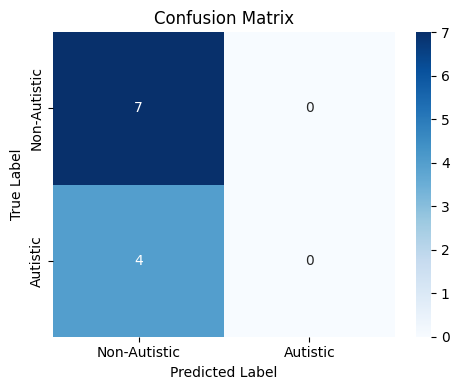

In [88]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, pred_labels)
print("\nConfusion Matrix:")
print(cm)
# 🔸 Optional: Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Autistic", "Autistic"], yticklabels=["Non-Autistic", "Autistic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## 1st attempt:
Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11


## 2nd attempt ( filtered NAN data)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11

## 3rd attempt (Using Batch Normalization)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11

# 4th attempt (Using LSTM)
Test Accuracy: 0.364

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.00      0.00      0.00         4

    accuracy                           0.36        11
   macro avg       0.25      0.29      0.27        11
weighted avg       0.32      0.36      0.34        11

## 5th attempt (Stratified sampling)

Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11

## 6th Attempt ( + Normalized data)
Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11

<Axes: title={'center': 'Attempt 3- Batch Normalization'}>

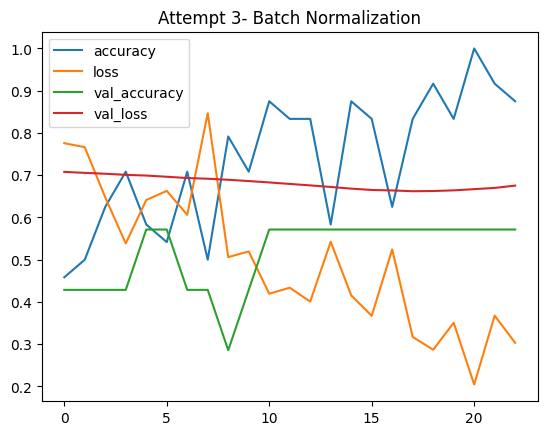

In [41]:
pd.DataFrame(history.history).plot(title="Attempt 3- Batch Normalization")

<Axes: title={'center': 'Attempt 4- with LSTM'}>

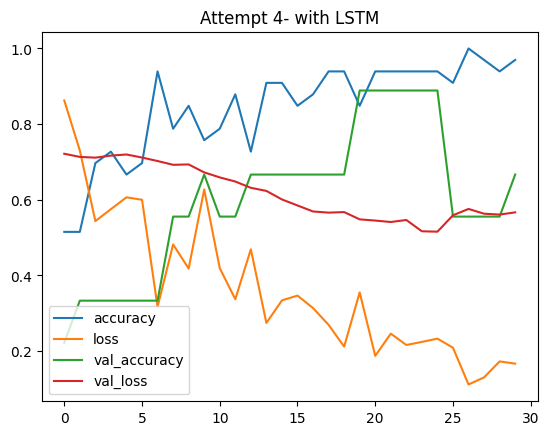

In [83]:
pd.DataFrame(history.history).plot(title="Attempt 4- with LSTM")

<Axes: title={'center': 'Attempt 5- stratified sampling'}>

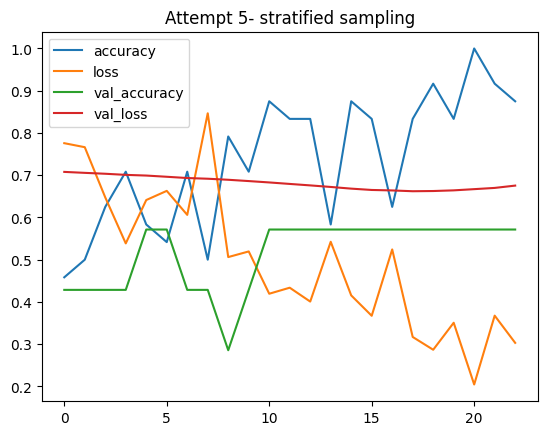

In [43]:
pd.DataFrame(history.history).plot(title="Attempt 5- stratified sampling")

<Axes: title={'center': 'Attempt 6- Normalized data + Strafied sampling'}>

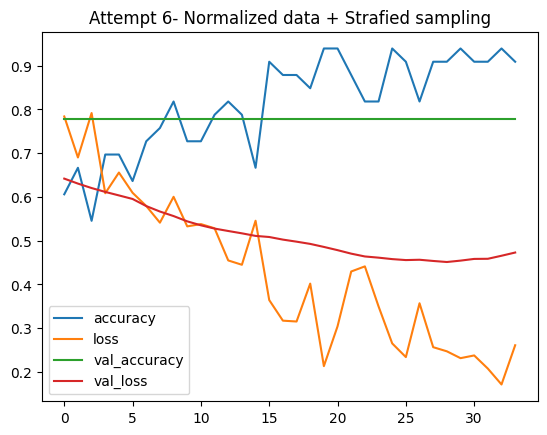

In [76]:
pd.DataFrame(history.history).plot(title="Attempt 6- Normalized data + Strafied sampling")

<Axes: title={'center': 'Attempt 7- 70:30 split'}>

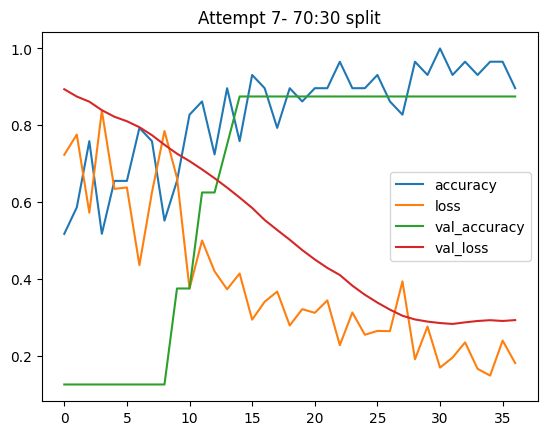

In [63]:
pd.DataFrame(history.history).plot(title="Attempt 7- 70:30 split")

<Axes: title={'center': ' Attempt 8- 80:40 split'}>

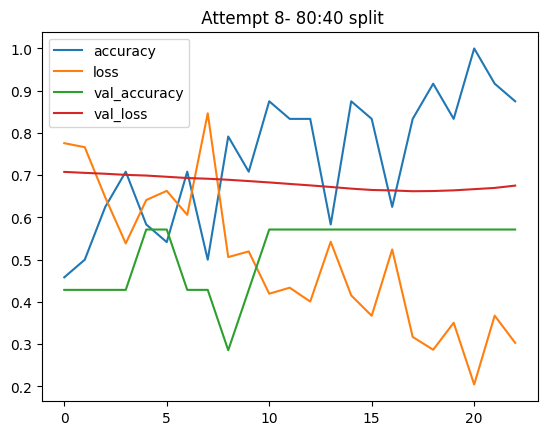

In [50]:
pd.DataFrame(history.history).plot(title=" Attempt 8- 80:40 split")

# ================================================================================

# Explanation

It prepares time-series data for each person into the shape expected by an LSTM model:

```python
X.shape → (num_samples, timesteps, num_features)  
y.shape → (num_samples,)
```

---

##  Step-by-Step Breakdown

```python
def prepare_sequences(df):
    grouped = df.groupby("sample_id")
```

###  `df.groupby("sample_id")`

This groups the dataframe by the **person ID** — each person (or sample) has a unique `sample_id`.

Assume your data looks like this:

| sample\_id | frame | feature1 | feature2 | ... | label         |
| ---------- | ----- | -------- | -------- | --- | ------------- |
| 0          | 0     | ...      | ...      |     | autistic      |
| 0          | 1     | ...      | ...      |     | autistic      |
| ...        | ...   | ...      | ...      |     | ...           |
| 1          | 0     | ...      | ...      |     | non\_autistic |

When you call:

```python
grouped = df.groupby("sample_id")
```

It organizes the data like:

```python
grouped = {
    0: DataFrame of 500 rows (frames) for person 0,
    1: DataFrame of 500 rows for person 1,
    ...
}
```

---

###  `for name, group in grouped:`

This loop goes through each group (i.e., each person’s 500-frame time series):

* `name`: the `sample_id` (e.g., 0, 1, 2, ...)
* `group`: the sub-DataFrame with 500 rows for that person

Sample Output:

```plaintext
name -> 0
group ->
   sample_id  frame  feature1  feature2  ...  label
0          0      0     ...       ...         autistic
1          0      1     ...       ...         autistic
...
499        0    499     ...       ...         autistic
```


###  `X.append(group[FEATURES].values)`

Here’s what happens:

* `FEATURES` is a list of your selected 11 features (e.g., knee\_angle, step\_width, etc.)
* `group[FEATURES].values` gives you a `(500, 11)` NumPy array
* You add that array to your list `X`

```python
X.append(group[FEATURES].values)  # shape: (500, 11)
```

---

###  `y.append(group["label"].values[0])`

Since the `label` is repeated in all 500 rows, we just take the **first** one:

```python
y.append(group["label"].values[0])  # 'autistic' or 'non_autistic'
```

So now:

* `X` is a list of shape `(num_samples, 500, 11)`
* `y` is a list of shape `(num_samples,)`

---

###  Final Return

```python
return np.array(X), np.array(y)
```

Let’s say you have 80 people:

```python
X.shape → (80, 500, 11)
y.shape → (80,)
```

Perfect for LSTM input!

---

##  Summary

| Component    | Shape/Type             | Purpose                                       |
| ------------ | ---------------------- | --------------------------------------------- |
| `groupby()`  | groups by person       | Makes it easy to loop over each person’s data |
| `X`          | `(n_samples, 500, 11)` | Time series input for LSTM                    |
| `y`          | `(n_samples,)`         | Class label for each person                   |
| `.values[0]` | scalar label           | All rows have same label, so pick first       |

In [46]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.model_selection import train_test_split

# # Load dataset
# time_series_df = pd.read_excel("train_gait_data.xlsx", sheet_name="time_series")
# static_df = pd.read_excel("train_gait_data.xlsx", sheet_name="static")

# FEATURES = [f"f{i}" for i in range(11)]

# def prepare_sequences(ts_df, static_df):
#     grouped = ts_df.groupby("sample_id")
#     X_seq, X_static, y = [], [], []

#     for sample_id, group in grouped:
#         X_seq.append(group[FEATURES].values)
#         static_row = static_df[static_df["sample_id"] == sample_id]
#         X_static.append(static_row[["cadence", "speed", "steps"]].values[0])
#         y.append(static_row["label"].values[0])

#     return np.array(X_seq), np.array(X_static), np.array(y)

# X_seq, X_static, y = prepare_sequences(time_series_df, static_df)

# # Split
# X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
#     X_seq, X_static, y, test_size=0.2, stratify=y, random_state=42
# )

# # Model
# def create_model(seq_input_shape, static_input_shape):
#     seq_input = keras.Input(shape=seq_input_shape, name="sequence_input")
#     x = layers.Masking()(seq_input)
#     x = layers.LSTM(64)(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(32, activation="relu")(x)

#     static_input = keras.Input(shape=static_input_shape, name="static_input")
#     s = layers.Dense(16, activation="relu")(static_input)

#     combined = layers.Concatenate()([x, s])
#     z = layers.Dense(32, activation="relu")(combined)
#     z = layers.Dropout(0.3)(z)
#     output = layers.Dense(1, activation="sigmoid")(z)

#     return keras.Model(inputs=[seq_input, static_input], outputs=output)

# model = create_model(X_seq.shape[1:], X_static.shape[1:])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# # Callbacks
# callbacks = [
#     keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
#     keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)
# ]

# # Train
# history = model.fit(
#     {"sequence_input": X_seq_train, "static_input": X_static_train},
#     y_train,
#     validation_split=0.2,
#     epochs=100,
#     batch_size=8,
#     callbacks=callbacks
# )

# # Evaluate
# model.evaluate(
#     {"sequence_input": X_seq_test, "static_input": X_static_test},
#     y_test,
#     verbose=1
# )


In [47]:
import numpy as np

a = np.array([[1], [2], [3]])   # Shape (3, 1)
b = np.array([[4], [5], [6]])   # Shape (3, 1)

np.hstack((a, b))


array([[1, 4],
       [2, 5],
       [3, 6]])

In [48]:
import re

text = "apple orange apple banana"
new_text = re.sub("apple", "grape", text)
print(new_text)

grape orange grape banana


In [98]:
subjects = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
            121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
            201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219]

side_sizes = [300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 279, 300, 300,
              300, 300, 283, 300, 300, 300, 258, 262, 300, 300, 300, 300, 300, 300,
              300, 300, 300, 300, 300, 300, 266, 300, 300, 269, 300, 270, 300, 300, 277, 239, 300, 300, 300]

front_sizes = [255, 255, 230, 255, 255, 255, 255, 224, 255, 223, 255, 255, 202, 255, 255, 255, 255, 255, 255, 255,
               255, 255, 255, 255, 255, 209, 255, 255, 255, 255, 255, 255, 255, 255,
               255, 213, 255, 240, 255, 255, 255, 255, 90, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
df=pd.DataFrame({
    "subject": subjects,
    "side_size":side_sizes,
    "front_size":front_sizes
})
print(df)
# Find subjects not meeting the requirement
bad_side_subjects = [subj for subj, size in zip(subjects, side_sizes) if size < 300]
bad_front_subjects = [subj for subj, size in zip(subjects, front_sizes) if size < 249]

print("\n❌ Subjects with insufficient side frames:", bad_side_subjects)
print("❌ Subjects with insufficient front frames:", bad_front_subjects)


    subject  side_size  front_size
0       101        300         255
1       102        300         255
2       103        300         230
3       104        300         255
4       105        300         255
5       106        300         255
6       107        300         255
7       108        300         224
8       109        300         255
9       110        300         223
10      111        300         255
11      112        300         255
12      113        300         202
13      114        300         255
14      115        300         255
15      116        300         255
16      117        300         255
17      118        279         255
18      119        300         255
19      120        300         255
20      121        300         255
21      122        300         255
22      123        283         255
23      124        300         255
24      125        300         255
25      126        300         209
26      127        258         255
27      128        2